### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/

/gdrive/My Drive


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
import sklearn

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
!unzip training_dataset_homework2.zip

Archive:  training_dataset_homework2.zip
replace y_train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace x_train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
denox = np.load('/gdrive/My Drive/x_train.npy')
denoy = np.load('/gdrive/My Drive/y_train.npy')
denox.shape, denoy.shape

((2429, 36, 6), (2429,))

In [ ]:
# Adding white noise 
wn = np.random.randn(2429*6*36)
wn = wn.reshape(2429,36,6)

In [ ]:
denox_new = 0.005*wn +(denox)

In [ ]:
denox_new

array([[[ 1.75994836e+01,  8.17060868e+00, -1.78096156e+00,
         -1.96983849e+01, -9.71467077e+00, -6.18881707e+01],
        [ 2.37636064e-01, -5.89176283e+00,  1.68346526e+01,
          5.04171280e+00,  2.43088291e+00,  5.89116714e+01],
        [-2.96527902e+01, -2.13055664e+01,  2.90943754e+01,
         -4.77841438e-01,  7.53859358e+01,  1.06665712e+01],
        ...,
        [ 1.19820291e+02,  2.18484285e+02,  1.63980179e+03,
          5.97872804e+02,  2.19220542e+03,  1.84892690e+01],
        [ 9.15841117e+01,  1.03775311e+02,  1.82380258e+03,
          1.24600257e+03,  1.13010026e+04,  7.51089264e+02],
        [ 4.37218545e+01,  3.06946778e+01,  9.50924770e+02,
          8.59273257e+02,  8.13309842e+03,  9.88833795e+02]],

       [[ 2.41703587e+00, -5.61574093e-01,  2.36515732e+01,
         -3.81669063e+00,  1.38367329e+00,  8.24166367e+00],
        [ 1.68813130e+00,  2.39809364e+01,  1.78006403e+01,
         -1.95695552e+01, -8.25307860e+00, -2.39643887e+01],
        [ 5.03343

In [ ]:
denox_merged = np.concatenate((denox,denox_new))
denoy_merged = np.concatenate((denoy,denoy))
denox_merged.shape

(4858, 36, 6)

### Exploration Data Analysis (EDA)
#### Human Activity Recognition

Load and clean the dataset

In [ ]:
# Split over users
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(denox_merged, denoy_merged, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4372, 36, 6), (486, 36, 6), (4372,), (486,))

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4372, 36, 6), (4372, 12), (486, 36, 6), (486, 12))

### Build and train models

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 150,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 5s 71ms/step - loss: 2.2175 - accuracy: 0.2827 - val_loss: 1.7911 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 15ms/step - loss: 1.7565 - accuracy: 0.4382 - val_loss: 1.5346 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 1.5279 - accuracy: 0.4743 - val_loss: 1.3610 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 0s 11ms/step - loss: 1.3810 - accuracy: 0.5247 - val_loss: 1.2499 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 1.2364 - accuracy: 0.5674 - val_loss: 1.1754 - val_accuracy: 0.5708 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 1.1596 - accuracy: 0.5984 - val_loss: 1.1460 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 0s 10ms/step - lo

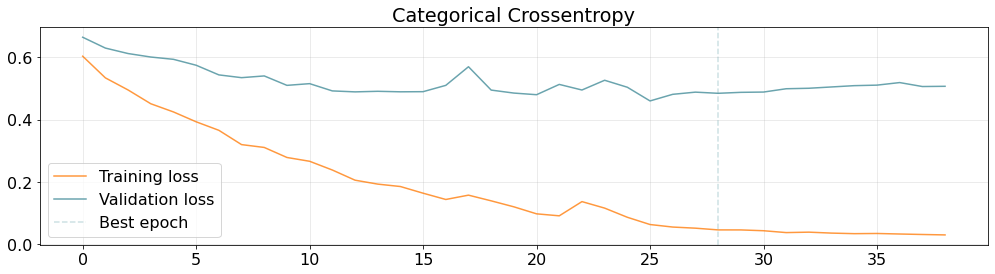

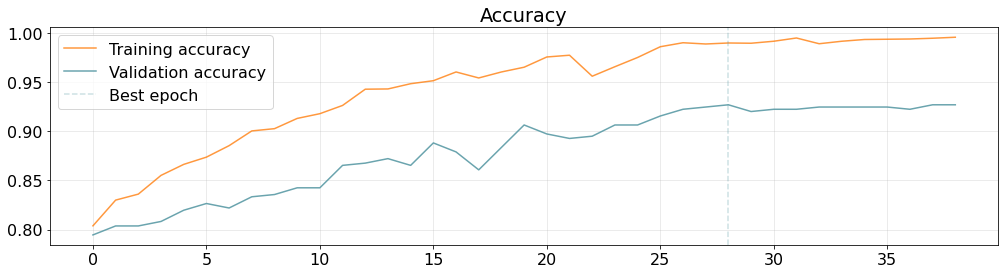

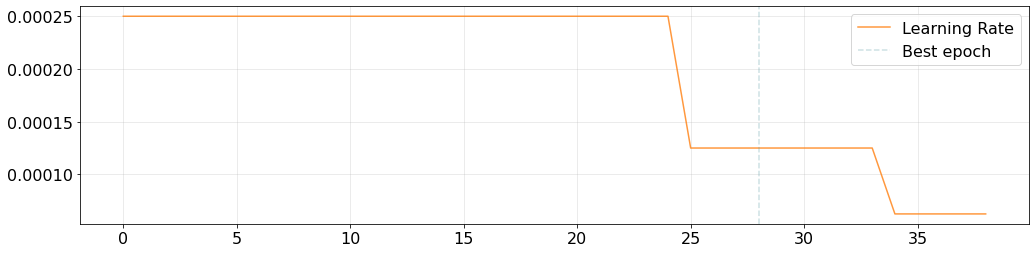

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('augmented_model')
# model = tfk.models.load_model('LSTM')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

8/8 [==============================] - 0s 4ms/step


(243, 12)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


Accuracy: 0.9877
Precision: 0.986
Recall: 0.985
F1: 0.9855


#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1CN-jJqzb5AurhnMMiuvdVCaPGy2KReLc
)

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 180,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
22/22 [==============================] - 1s 26ms/step - loss: 0.2992 - accuracy: 0.9288 - val_loss: 0.5042 - val_accuracy: 0.8790 - lr: 3.1250e-05
Epoch 2/200
22/22 [==============================] - 0s 19ms/step - loss: 0.2648 - accuracy: 0.9347 - val_loss: 0.4891 - val_accuracy: 0.8790 - lr: 3.1250e-05
Epoch 3/200
22/22 [==============================] - 1s 24ms/step - loss: 0.2422 - accuracy: 0.9375 - val_loss: 0.4649 - val_accuracy: 0.8836 - lr: 3.1250e-05
Epoch 4/200
22/22 [==============================] - 1s 27ms/step - loss: 0.2270 - accuracy: 0.9403 - val_loss: 0.4536 - val_accuracy: 0.8836 - lr: 3.1250e-05
Epoch 5/200
22/22 [==============================] - 1s 22ms/step - loss: 0.2092 - accuracy: 0.9453 - val_loss: 0.4369 - val_accuracy: 0.8858 - lr: 3.1250e-05
Epoch 6/200
22/22 [==============================] - 0s 20ms/step - loss: 0.1952 - accuracy: 0.9479 - val_loss: 0.4251 - val_accuracy: 0.8881 - lr: 3.1250e-05
Epoch 7/200
22/22 [===========================

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

KeyboardInterrupt: ignored

<Figure size 1224x288 with 0 Axes>

In [ ]:
model.save('BiLSTM_noisymerged')
# model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 0s 6ms/step


(486, 12)

In [ ]:

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



Accuracy: 0.9712
Precision: 0.9443
Recall: 0.969
F1: 0.9552


#### 1D Convolutional Neural Network

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 128)               0     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
16/16 [==============================] - 6s 42ms/step - loss: 2.4032 - accuracy: 0.2964 - val_loss: 2.2241 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 2.2156 - accuracy: 0.3432 - val_loss: 1.9830 - val_accuracy: 0.3927 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 2.0580 - accuracy: 0.3472 - val_loss: 1.8745 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 1.9560 - accuracy: 0.3686 - val_loss: 1.8230 - val_accuracy: 0.3927 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 12ms/step - loss: 1.9030 - accuracy: 0.3762 - val_loss: 1.7758 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 14ms/step - loss: 1.8650 - accuracy: 0.3803 - val_loss: 1.7449 - val_accuracy: 0.4292 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 13ms/step - lo

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('1DCNN')
# model = tfk.models.load_model('1DCNN')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

8/8 [==============================] - 0s 6ms/step


(243, 12)

In [ ]:

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


Accuracy: 0.5473
Precision: 0.5064
Recall: 0.4597
F1: 0.4325


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Damn, once again no free lunch